In [11]:
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import MT5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import accuracy_score

In [4]:
class SoftEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,
                n_tokens: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        """appends learned embedding to 
        Args:
            wte (nn.Embedding): original transformer word embedding
            n_tokens (int, optional): number of tokens for task. Defaults to 10.
            random_range (float, optional): range to init embedding (if not initialize from vocab). Defaults to 0.5.
            initialize_from_vocab (bool, optional): initalizes from default vocab. Defaults to True.
        """
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                                  n_tokens, 
                                                                                  random_range, 
                                                                                  initialize_from_vocab))
            
    def initialize_embedding(self, 
                             wte: nn.Embedding,
                             n_tokens: int = 10, 
                             random_range: float = 0.5, 
                             initialize_from_vocab: bool = True):
        """initializes learned embedding
        Args:
            same as __init__
        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)
            
    def forward(self, tokens):
        """run forward pass
        Args:
            tokens (torch.long): input tokens before encoding
        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

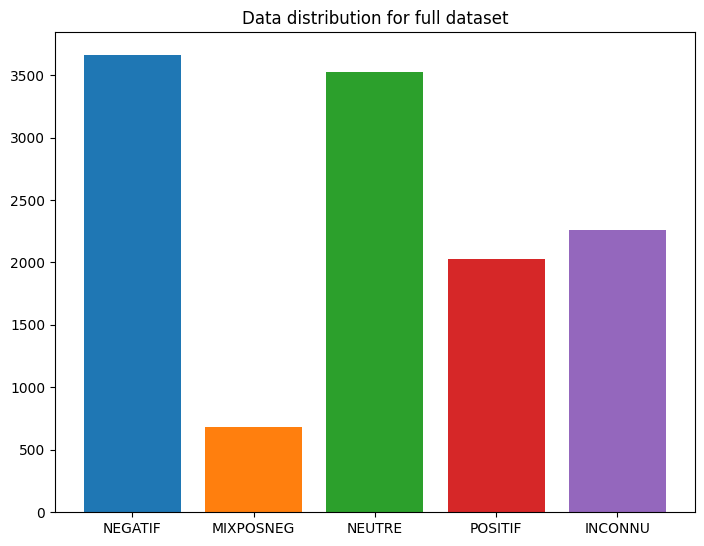

In [8]:
def plot_fig(df, split):
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    for label in df["Polarité"].unique():
        len_label = len(df[df["Polarité"] == label])
        ax.bar(label, [len_label])
        
    ax.set_title(f"Data distribution for {split} dataset")
    
def undersampling(df, frac=None):
    
    pos = df[df["Polarité"] == "POSITIF"]

    if frac is not None:
        neg = df[df["Polarité"] == "NEGATIF"].sample(n=round(len(pos)*frac))
    else:
        neg = df[df["Polarité"] == "NEGATIF"]
        
    return pd.concat([neg,pos]).sample(frac=1)

SEED = 42

train_df = pd.read_csv('datasets/corpus_2018_deft_tweets.txt', sep='\t').dropna().sample(frac=0.2, random_state=SEED)
test_df = pd.read_csv('datasets/deft2018_test.csv', sep='\t', names = train_df.columns).dropna().sample(frac=0.2, random_state=SEED)
dev_df = pd.read_csv('datasets/deft2018_dev.csv', sep='\t', names = train_df.columns).dropna().sample(frac=0.2, random_state=SEED)

full_dataset = pd.concat([train_df, test_df, dev_df]).reset_index()
plot_fig(full_dataset, split="full")

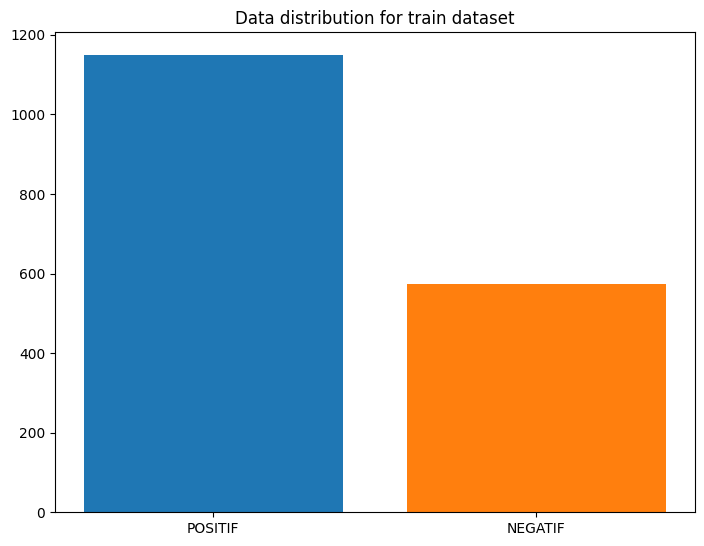

In [12]:
## undersampling & only keeping 'negative' & 'positive' columns

train = undersampling(train_df, frac=0.5)
test = undersampling(test_df)
dev = undersampling(dev_df)

dataset = pd.concat([train,test,dev]).reset_index()
dataset.to_csv('binary_classif_deft2018.txt', sep="\t")

## plot train dataset
plot_fig(train, split='train')

X_train, y_train = train['Texte'], train['Polarité']
X_test, y_test = test['Texte'], test['Polarité']
X_dev, y_dev = dev['Texte'], dev['Polarité']

In [6]:
mapping = {'NEGATIF': 0, 'POSITIF': 1}

In [7]:
def generate_data(batch_size, n_tokens, title_data, label_data):

    labels = [
        torch.tensor([[3]]),  # \x00
        torch.tensor([[4]]),  # \x01
        torch.tensor([[5]]),
    ]

    def yield_data(x_batch, y_batch, l_batch):
        x = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True)
        y = torch.cat(y_batch, dim=0)
        m = (x > 0).to(torch.float32)
        decoder_input_ids = torch.full((x.size(0), n_tokens), 1)
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            m = m.cuda()
            decoder_input_ids = decoder_input_ids.cuda()
        return x, y, m, decoder_input_ids, l_batch

    x_batch, y_batch, l_batch = [], [], []
    for x, y in zip(title_data, label_data):
        context = x
        inputs = tokenizer(context, return_tensors="pt")
        inputs['input_ids'] = torch.cat([torch.full((1, n_tokens), 1), inputs['input_ids']], 1)
        y = mapping[y]
        l_batch.append(y)
        y = labels[y]
        y = torch.cat([torch.full((1, n_tokens - 1), -100), y], 1)
        x_batch.append(inputs['input_ids'][0])
        y_batch.append(y)
        if len(x_batch) >= batch_size:
            yield yield_data(x_batch, y_batch, l_batch)
            x_batch, y_batch, l_batch = [], [], []

    if len(x_batch) > 0:
        yield yield_data(x_batch, y_batch, l_batch)
        x_batch, y_batch, l_batch = [], [], []

In [8]:
DEVICE = "cuda:1"

model = MT5ForConditionalGeneration.from_pretrained("google/mt5-base")
tokenizer = T5Tokenizer.from_pretrained("google/mt5-base")
n_tokens = 100

s_wte = SoftEmbedding(model.get_input_embeddings(), 
                      n_tokens=n_tokens, 
                      initialize_from_vocab=True)

model.set_input_embeddings(s_wte)

if torch.cuda.is_available():
    model = model.to(DEVICE)
    
print(f'model device is {model.device}')

model device is cuda:1


In [9]:
parameters = list(model.parameters())

for x in parameters[1:]:
    x.requires_grad = False

In [10]:
batch_size = 16

for x, y, m, dii, true_labels in generate_data(batch_size, n_tokens, X_train, y_train):
    assert dii.shape == y.shape
    outputs = model(input_ids=x.to(model.device), labels=y.to(model.device), attention_mask=m.to(model.device), decoder_input_ids=dii.to(model.device))
    assert outputs['logits'].shape[:2] == y.shape
    pred_labels = outputs['logits'][:, -1, 3:6].argmax(-1).detach().cpu().numpy().tolist()
    break

In [11]:
n_epoch = 10
total_batch = math.ceil(len(X_train) / batch_size)
dev_total_batch = math.ceil(len(X_dev) / batch_size)
use_ce_loss = True
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(s_wte.parameters(), lr=1e-5)

for epoch in range(n_epoch):
    print('epoch', epoch+1)

    all_true_labels = []
    all_pred_labels = []
    losses = []
    pbar = tqdm(enumerate(generate_data(batch_size, n_tokens, X_train, y_train)), total=total_batch)
    for i, (x, y, m, dii, true_labels) in pbar:
        all_true_labels += true_labels
        
        optimizer.zero_grad()
        outputs = model(input_ids=x.to(model.device), labels=y.to(model.device), attention_mask=m.to(model.device), decoder_input_ids=dii.to(model.device))
        pred_labels = outputs['logits'][:, -1, 3:6].argmax(-1).detach().cpu().numpy().tolist()
        all_pred_labels += pred_labels

        if use_ce_loss:
            logits = outputs['logits'][:, -1, 3:6].to(model.device)
            true_labels_tensor = torch.tensor(true_labels, dtype=torch.long).cuda().to(model.device)
            loss = ce_loss(logits, true_labels_tensor)
        else:
            loss = outputs.loss
            
        loss.backward()
        optimizer.step()
        loss_value = float(loss.detach().cpu().numpy().tolist()) / batch_size
        losses.append(loss_value)

        acc = accuracy_score(all_true_labels, all_pred_labels)
        pbar.set_description(f'train: loss={np.mean(losses):.4f}, acc={acc:.4f}')

    all_true_labels = []
    all_pred_labels = []
    losses = []
    with torch.no_grad():
        pbar = tqdm(enumerate(generate_data(batch_size, n_tokens, X_dev, y_dev)), total=dev_total_batch)
        
        for i, (x, y, m, dii, true_labels) in pbar:
            all_true_labels += true_labels
            outputs = model(input_ids=x.to(model.device), labels=y.to(model.device), attention_mask=m.to(model.device), decoder_input_ids=dii.to(model.device))
            loss = outputs.loss
            loss_value = float(loss.detach().cpu().numpy().tolist()) / batch_size
            losses.append(loss_value)
            pred_labels = outputs['logits'][:, -1, 3:6].argmax(-1).detach().cpu().numpy().tolist()
            all_pred_labels += pred_labels
            acc = accuracy_score(all_true_labels, all_pred_labels)
            pbar.set_description(f'dev: loss={np.mean(losses):.4f}, acc={acc:.4f}')

epoch 1


dev: loss=3.4048, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.88it/s]


epoch 2


dev: loss=3.4090, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]


epoch 3


dev: loss=3.4072, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]


epoch 4


dev: loss=3.4124, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.83it/s]


epoch 5


dev: loss=3.3923, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.83it/s]


epoch 6


dev: loss=3.4269, acc=0.6381: 100%|██████████| 102/102 [00:26<00:00,  3.83it/s]


epoch 7


dev: loss=3.4271, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.83it/s]


epoch 8


dev: loss=3.4296, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.84it/s]


epoch 9


dev: loss=3.4135, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.83it/s]


epoch 10


dev: loss=3.4223, acc=0.6387: 100%|██████████| 102/102 [00:26<00:00,  3.84it/s]


In [12]:
torch.save(model.state_dict(), 'model_weights.pth')

In [13]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [14]:
def predict(text):
    
    inputs = tokenizer(text, return_tensors='pt')
    inputs['input_ids'] = torch.cat([torch.full((1, n_tokens), 1), inputs['input_ids']], 1)

    decoder_input_ids = torch.full((1, n_tokens), 1)
    with torch.no_grad():
        outputs = model(input_ids=inputs['input_ids'].to(model.device), decoder_input_ids=decoder_input_ids.to(model.device))
    logits = outputs['logits'][:, -1, 3:6]
    pred = logits.argmax(-1).detach().cpu().numpy()[0]
    
    return pred

In [15]:
train_rets = []

for X,y in zip(X_train,y_train):
    pred = predict(X)
    mapped_pred = [k for k, v in mapping.items() if v == pred][0]
    print(f'pred : {mapped_pred} / true : {y}')
    train_rets.append((y, mapped_pred, X))

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : N

In [16]:
rets = []

for X,y in zip(X_test,y_test):
    pred = predict(X)
    mapped_pred = [k for k, v in mapping.items() if v == pred][0]
    print(f'pred : {mapped_pred} / true : {y}')
    train_rets.append((y, mapped_pred, X))

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : N

pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : N

pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : POSITIF
pred : NEGATIF / true : NEGATIF
pred : NEGATIF / true : NEGATIF
pred : N

In [17]:
# accuracy for train set

print(
    accuracy_score(
        [x[0] for x in train_rets],
        [x[1] for x in train_rets],
    )
)

0.43212312549329124


In [18]:
# accuracy for test set

print(
    accuracy_score(
        [x[0] for x in rets],
        [x[1] for x in rets],
    )
)

nan


/opt/conda/envs/mkultra-env/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/mkultra-env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
test_df['Texte'][100], test_df['Polarité'][100]

('@musulmanfrance Rien à côté de ce raciste qui m\' a giflé (j\' ai 76 ans) sur le quai du RER en criant \\\\sale blanc\\\\".La violence,c\' est plus grave"',
 'NEGATIF')

In [20]:
pred = predict("PokéTip : Le bouton transférer se situe maintenant dans le menu en bas à droite ! #PokemonGO https://t.co/MEdT24Hohl")
pred = [k for k, v in mapping.items() if v == pred][0]

pred

'NEGATIF'